<a href="https://colab.research.google.com/github/kpjaskie/SenSIP-IRES2020/blob/master/SolarData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Solar Data

In this section, we will load the solar data into Colab and put it into two arrays - one, named X, will contain all of the known data with 10 features, and the other, y, will contain the class numbers for each datapoint in X

In [0]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd

In [0]:
from google.colab import files
uploaded = files.upload()

Saving asu_solar_dataset.csv to asu_solar_dataset (1).csv


In [0]:
data_path = '/content/asu_solar_dataset.csv'
df = pd.read_csv(data_path, delimiter=',')  #here we're reading our csv file into a Pandas DataFrame

In [0]:
# This is what our dataframe looks like to begin with
df.loc[0:2, :]  # We're only looking at the first three rows

,DCArrayOutput_W_,Vmp,Imp,CellTemperature_C_,PlaneOfArrayIrradiance_W_m_2_,Fill Factor,Gamma,Pmp,Voc,Isc,Degraded,Shaded,Soiled,SC,STC
0,4715.409,36.331723,1.369981,16.107,281.111,4.669695,0.177061,49.773762,44.338856,5.242090,0,0,0,0,1
1,9076.926,37.436438,2.559325,26.713,527.216,2.391698,0.181732,95.811997,44.023777,5.205219,0,0,0,0,1
2,11978.364,35.924148,3.519590,36.542,712.905,1.913899,0.177356,126.438287,45.239121,5.349134,0,0,0,0,1


In [0]:
# We're going to start by separating the data from the labels.  Here, 
# we delete the labels to isolate the data into a new dataframe

df_X = df.drop(columns=['Degraded', 'Shaded', 'Soiled', 'SC', 'STC'])
df_X.loc[0:2,:] #Look at the dataframe to verify the 

,DCArrayOutput_W_,Vmp,Imp,CellTemperature_C_,PlaneOfArrayIrradiance_W_m_2_,Fill Factor,Gamma,Pmp,Voc,Isc
0,4715.409,36.331723,1.369981,16.107,281.111,4.669695,0.177061,49.773762,44.338856,5.242090
1,9076.926,37.436438,2.559325,26.713,527.216,2.391698,0.181732,95.811997,44.023777,5.205219
2,11978.364,35.924148,3.519590,36.542,712.905,1.913899,0.177356,126.438287,45.239121,5.349134


In [0]:
# Here, we drop the data to obtain the labels.  We put them in their own dataframe.

df_y = df.drop(columns=['DCArrayOutput_W_', 'Vmp', 'Imp', 'CellTemperature_C_', 
                        'PlaneOfArrayIrradiance_W_m_2_', 'Fill Factor', 'Gamma',
                        'Pmp', 'Voc', 'Isc'])
df_y.loc[1:3,:] #Labels in a one-hot encoding

,Degraded,Shaded,Soiled,SC,STC
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1


In [0]:
#Now we convert the data into a numpy array - many of the algorithms we're 
#interested in will only take numpy arrays, not dataframes
X = df_X.to_numpy()
X[:3,:] #check to make sure it converted it properly

array([[4.71540900e+03, 3.63317230e+01, 1.36998076e+00, 1.61070000e+01,
        2.81111000e+02, 4.66969485e+00, 1.77060882e-01, 4.97737617e+01,
        4.43388563e+01, 5.24209008e+00],
       [9.07692600e+03, 3.74364378e+01, 2.55932461e+00, 2.67130000e+01,
        5.27216000e+02, 2.39169826e+00, 1.81731959e-01, 9.58119967e+01,
        4.40237770e+01, 5.20521867e+00],
       [1.19783640e+04, 3.59241479e+01, 3.51959042e+00, 3.65420000e+01,
        7.12905000e+02, 1.91389893e+00, 1.77356431e-01, 1.26438287e+02,
        4.52391213e+01, 5.34913355e+00]])

In [0]:
# Data labels are originally stored in a one-hot encoding, meaning that each 
# column represents a fault type and contains either a zero or a 1
y_onehot = df_y.to_numpy()
y_onehot[:3,:]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [0]:
# We will covert the one-hot encoding into integer class numbers.
y = np.argmax(y_onehot, axis=1)

# Here, 0 = degraded
#       1 = shaded
#       2 = soiled
#       3 = short circuit
#       4 = standard test conditions (no faults)

print(y)
print(y.shape)

[4 4 4 ... 1 1 1]
(21485,)


# Visualize the Data

In order to visualize the 10 dimensional data effectively, we're going to perform a dimensionality reduction algorithm called PCA (Principal Component Analysis).  This uses Singular Value Decomposition to identify the eigenvectors in the data, and removes all but the most important.

In [0]:
from sklearn.decomposition import PCA

# Transform the data into a dimensionality reduced dataset in 3 dimensions
pca_model3 = PCA(n_components=3)
X_red3 = pca_model3.fit_transform(X)  #X_red is short for X_reduced3

In [0]:
X_red3[1:3,:]

array([[ 1.80730409e+03, -1.28337250e+02, -5.74421433e+00],
       [ 4.71475626e+03, -1.50077960e+02,  4.17291284e+00]])

In [0]:
# Here, we can plot the reduced data in three dimensions

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=X_red3[:,0], y=X_red3[:,1], z=X_red3[:,2], 
                                   mode='markers', 
                                   marker=dict(
                                       size=5,
                                       color=y,                
                                       opacity=0.8))])

fig.show()

#Notice that 

Hmmm.... It looks like the third dimension doesn't really add that much.  Let's see what happens if we plot it in only two dimensions

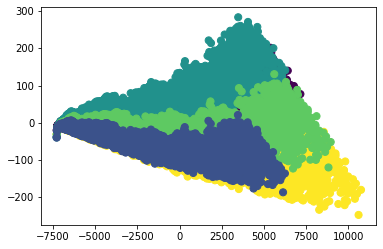

In [0]:
# Transform the data into a dimensionality reduced dataset in 2 dimensions
pca_model2 = PCA(n_components=2)
X_red2 = pca_model2.fit_transform(X)  #X_red2 is short for X_reduced2

plt.scatter(X_red2[:, 0], X_red2[:, 1], s=50, c=y)


#Legend:
#   degraded = purple
#   blue = shaded
#   cyan = soiled
#   green = short circuit
#   yellow = STC (no faults or problems)

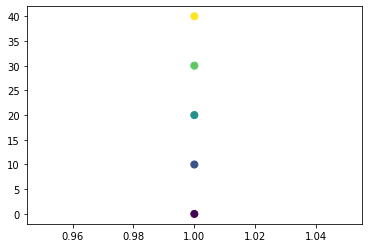

In [0]:
temp1 = [1, 1, 1, 1, 1]
temp2 = [0, 10, 20, 30, 40]
temp_y = [0, 1, 2, 3, 4]

plt.scatter(temp1, temp2, s=50, c=temp_y)